In [1]:
#| default_exp activations

In [2]:
import sys
sys.path.insert(1, '/home/umangkaushik/projects/my_fastai_part2')

# Activation Stats

In [3]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [4]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

- `mpl.rcParams['figsize.constrained_layout.use'] = True` means constrained layout will be enabled by default for all figures created using Matplotlib.
- This ensures that the layout of figures is automatically adjusted to avoit overlapping elements.

In [5]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [6]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [8]:
def cnn_layers():
    return [
        conv(1, 8, ks=5),           # 14x14
        conv(8, 16),                # 7x7
        conv(16, 32),               # 4x4
        conv(32, 64),               # 2x2
        conv(64, 10, act=False),    # 1x1
        nn.Flatten()
    ]

In [9]:
from torcheval.metrics import MulticlassAccuracy

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [11]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs + fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

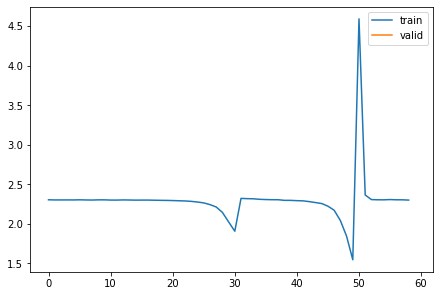

In [12]:
set_seed(69)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

functions that automatically execute after a particular event

### Manual Insertion

In [13]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


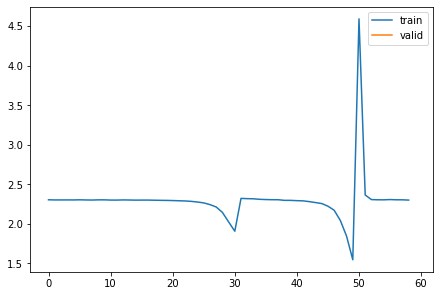

In [14]:
set_seed(69)
model = SequentialModel(*cnn_layers())
learn = fit(model)

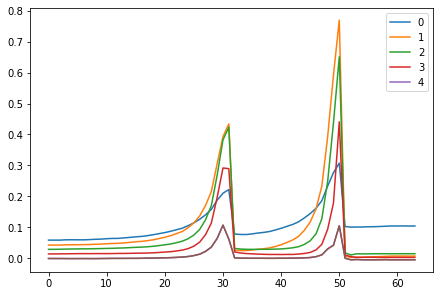

In [15]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

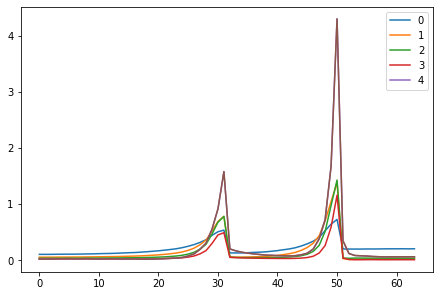

In [16]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### PyTorch Hooks

- In PyTorch, hooks are object that can be added to any nn.Module.
- A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook)

In [17]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output.

In [18]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [19]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [20]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

- The purpose of the hook is to collect stats or perform certain actions during the forward pass of the model.
- `register_forward_hook` function allows you to specify a function that will be called every time the module performs a forward pass.

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


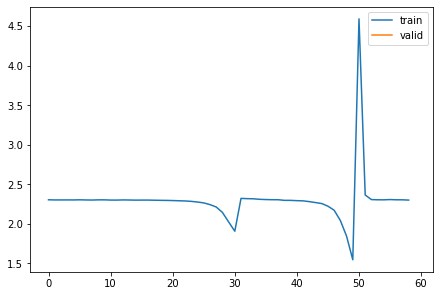

In [21]:
fit(model)

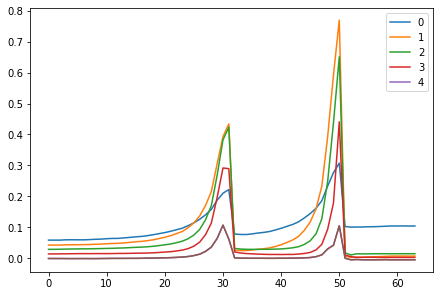

In [22]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook Class

- It is very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when the model is deleted.

In [23]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [24]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [25]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

In [26]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

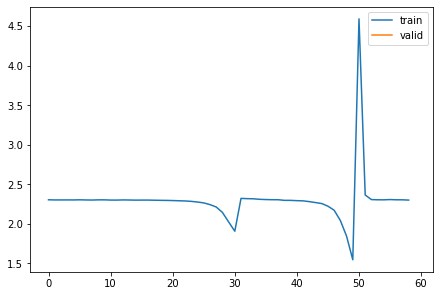

In [27]:
learn = fit(model)

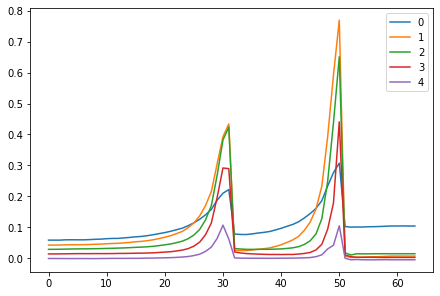

In [28]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

In [29]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [30]:
set_seed(69)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


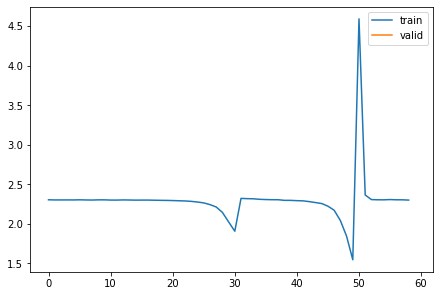

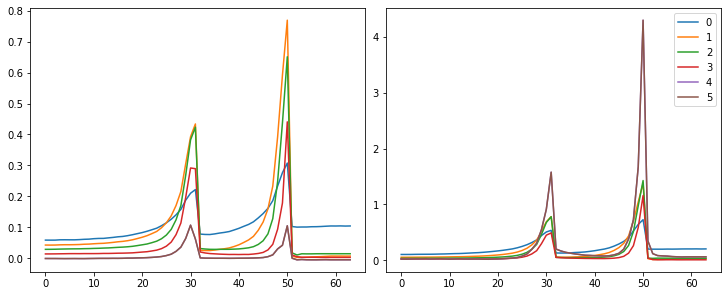

In [31]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### Hooks Callback

In [32]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
        
    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
        
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)
            
    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

`before_fit(self, learn)`
- called before the training loop begins.
- it retrieves the list of modules to attach hooks to, either from the provided `mods` attribute or by filtering the modules in `learn.model` using the `mod_filter` function.
- it then creates a `Hooks` instance, passing the list of modules and partially applied version of `_hookfunc` method, which includes the `learn` object.

`_hookfunc(self, learn, *args, **kwargs)`
- called when the hooks are triggered
- checks whether the current phase is either training or validation, and if so, it calls the `hookfunc` with the provided arguments.

`after_fit(self, learn)`
- called after the training loop ends.
- it removes the hooks by calling the `remove` method of the `Hooks` instance.

- `fc.noop` ("no-operation") is a function that does nothing and serves as a placeholder or default value for a function argument.
- it is typically used when a function requires a function arguments but you don't want to perform any specific operation or provide a custom function.

In [33]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.148,2.293,0,train
0.100,2.303,0,eval


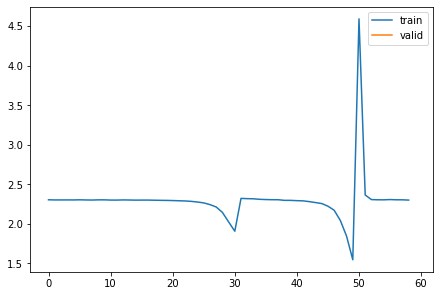

In [34]:
set_seed(69)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

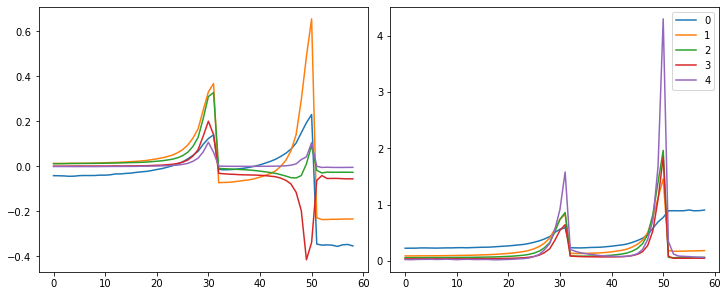

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in 0, 1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [36]:
#|export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

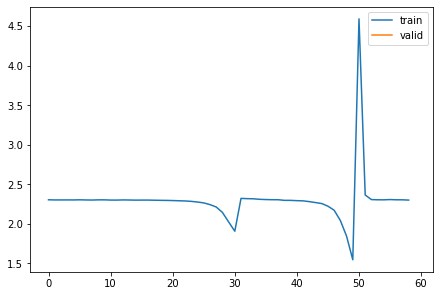

In [37]:
set_seed(69)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [38]:
#|export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

- `get_hist(h)` takes a hook as input and returns a histogram of the activaton values stored in the `h.stats[2]` attribute of the hook.
- `torch.stack(h.stats[2])` is used to stack the activation values retrieved from `h.stats[2]` along a new dimension, creating a tensor with shape `(num_samples, num_activation_values)`.
- `.lop1p()` function computes the natural logarithm of `1 + x`, where `x` is the input tensor.
By adding1 before taking the logrithm, it ensures that the logarithm is well-defined even for small or zero activation values.

In [39]:
fig, axes = get_grid(len(hc), figsize=(11,5))
for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0] / h1.sum(0)

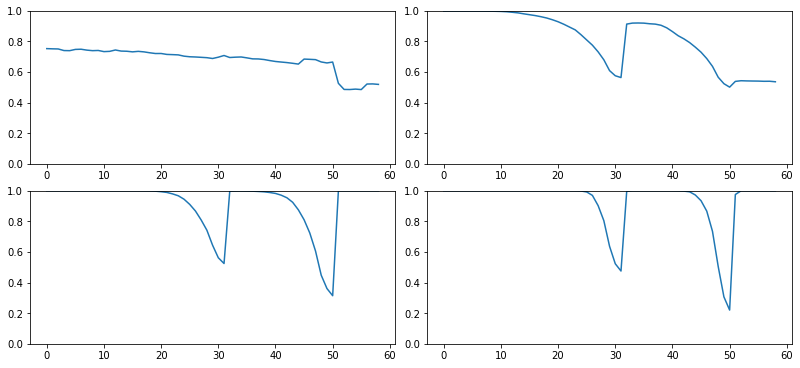

In [ ]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)

## Activation Stats

In [ ]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)
        
    def color_dim(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
            
    def dead_chart(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)
            
    def plot_stats(self, figsize=(10, 4)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0, 1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

`ActivationStats`
- `color_dim(self, figsize=(11, 5))`
    - It creates a grid of subplots and visualizes the histogram of activation values for each hook in the `ActivationStats` instance.
    - It uses the `get_grid` function to create the subplots and plots the minimum activation values using `ax.plot`.
- `dead_chart(self, figsize=(11, 5))`
    - It creates a grid of subplots and plots the minimum activation value over time for each hook in the instance.
    - It used the `get_grid` to create the subplots and plots the minimum activation values using `ax.plot`
- `plot_stats(self, figsize=(10, 4))`
    - It creates a figure with two subplots and plots the mean and std deviations of the activation stats over time for each hook in the instance.
    - It uses `plt.subplots` to create the figure and plots the stats using `ax.plot`.
    - A legend is added to differentiate the hooks using `fc.L.range(self)`.

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

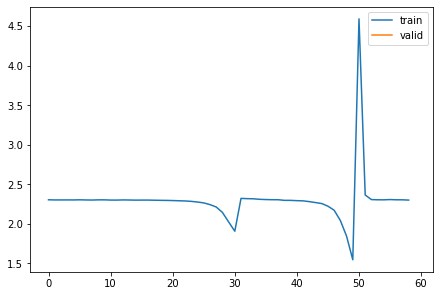

In [ ]:
set_seed(69)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

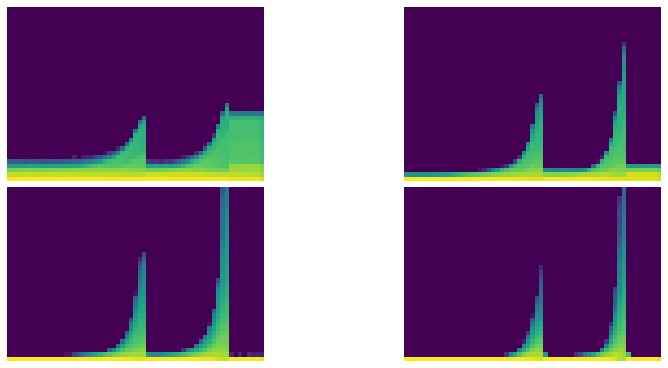

In [ ]:
astats.color_dim()

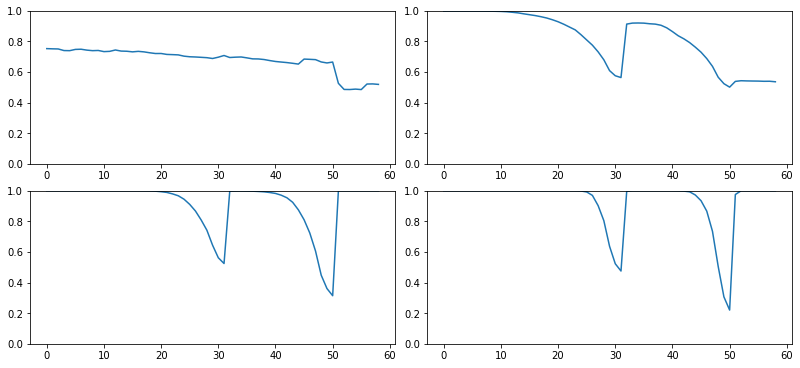

In [ ]:
astats.dead_chart()

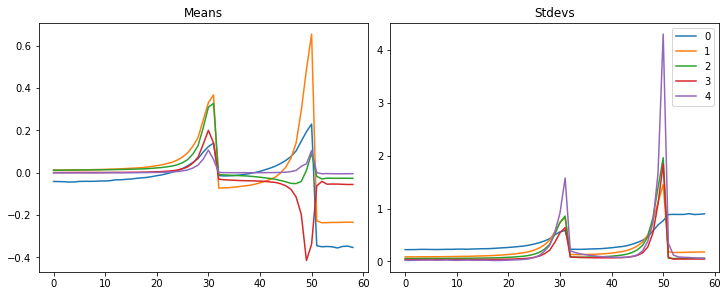

In [ ]:
astats.plot_stats()

# Export -

In [40]:
import nbdev
nbdev.nbdev_export()